# プロ野球データによるセイバーメトリクス
## 1. 事前に
### 1.1. データのダウンロード
- プロ野球データFreak(http://baseball-data.com/) から、2015年における全球団んの打撃成績および2016年における野手の年俸上位100選手のデータを使用。
- 実際はデータサイエンティスト養成読本のサポートサイト(http://gihyo.jp/book/2017/978-4-7741-8877-5/support) より各csvファイルをダウンロードして使用。

### 1.2. モジュールのダウンロード

In [75]:
# Calculate
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
# Static model
import statsmodels.formula.api as smf
# Graph
import matplotlib.pyplot as plt
import seaborn as sns
# Set graph font and style.
plt.rcParams['font.family'] = 'IPAexGothic'
plt.style.use('ggplot')
%matplotlib inline

## 2. クロス集計で比較
### 2.1. 使用するデータについて
- batterに打撃成績データを、nenpoに年俸データを読み込む。
- 基本的なデータの保存形式はこのように、整理データでかつ縦持ちデータであることが適切。
- 縦持ちデータで前処理を進めて、可視化やクロス集計を行う際に横持ちデータにするのが効率的。

In [3]:
batter = pd.read_csv('batting-record.csv', encoding='shift-jis')
batter.head()

,Name,League,Team_15,AVG,AB,H,HR,RBI,SLG,OBP,OPS,RC,RC27,XR,XR27
0,山田 哲人,セ,ヤクルト,0.329,557,183,38,100,0.610,0.416,1.027,138.74,9.56,133.36,9.19
1,川端 慎吾,セ,ヤクルト,0.336,581,195,8,57,0.439,0.383,0.822,93.68,6.20,88.39,5.85
2,雄平,セ,ヤクルト,0.270,551,149,8,60,0.388,0.307,0.695,64.96,4.21,63.25,4.10
3,畠山 和洋,セ,ヤクルト,0.268,512,137,26,105,0.471,0.344,0.815,83.78,5.76,85.19,5.85
4,中村 悠平,セ,ヤクルト,0.231,442,102,2,33,0.276,0.299,0.575,36.74,2.70,37.46,2.76


In [4]:
nenpo = pd.read_csv('annual-salary.csv', encoding='shift-jis')
nenpo.head()

,Name,Team_16,Salary,Position,Age,Height,Weight
0,中村 剛也,西武,41000,内野手,32,175,102
1,鳥谷 敬,阪神,40000,内野手,35,180,79
2,バレンティン,ヤクルト,36000,外野手,32,185,100
3,中島 宏之,オリックス,35000,内野手,33,180,90
4,内川 聖一,ソフトバンク,33000,外野手,33,185,93


### 2.2. データの結合
- 打撃成績と年俸のデータを内部統合し、年俸上位100人に含まれる打者のデータに絞る。

In [5]:
# Merge data and filter the batter who the salary is in top 100.
data = pd.merge(batter, nenpo, on='Name', how='inner')
data.head()

,Name,League,Team_15,AVG,AB,H,HR,RBI,SLG,OBP,...,RC,RC27,XR,XR27,Team_16,Salary,Position,Age,Height,Weight
0,山田 哲人,セ,ヤクルト,0.329,557,183,38,100,0.610,0.416,...,138.74,9.56,133.36,9.19,ヤクルト,22000,内野手,24,180,76
1,川端 慎吾,セ,ヤクルト,0.336,581,195,8,57,0.439,0.383,...,93.68,6.20,88.39,5.85,ヤクルト,16000,内野手,28,185,86
2,雄平,セ,ヤクルト,0.270,551,149,8,60,0.388,0.307,...,64.96,4.21,63.25,4.10,ヤクルト,6500,外野手,32,174,83
3,畠山 和洋,セ,ヤクルト,0.268,512,137,26,105,0.471,0.344,...,83.78,5.76,85.19,5.85,ヤクルト,13000,内野手,33,180,96
4,中村 悠平,セ,ヤクルト,0.231,442,102,2,33,0.276,0.299,...,36.74,2.70,37.46,2.76,ヤクルト,6700,捕手,26,176,83


- チームごとの合計年俸を数値で示す。

In [6]:
# Calculate the sum of estimated annual salary per team.
res = data.groupby('Team_16', as_index=False)['Salary'].sum()
# Arrange in descending order by Salary.
res = res.sort_values(by=['Salary'], ascending=False).reset_index(drop=True)
res.head()

,Team_16,Salary
0,巨人,150600
1,西武,111000
2,ソフトバンク,110000
3,阪神,85300
4,日本ハム,84500


- チームごとの合計年俸を比率で示す。

In [7]:
data['Salary_per'] = data['Salary'] / data['Salary'].sum() * 100
res2 = data.groupby('Team_16', as_index=False)['Salary_per'].sum()
res2 = res2.sort_values(by=['Salary_per'], ascending=False).reset_index(drop=True)
res2['Salary_per_cumsum'] = res2['Salary_per'].cumsum()
res2.head()

,Team_16,Salary_per,Salary_per_cumsum
0,巨人,15.762371,15.762371
1,西武,11.617684,27.380055
2,ソフトバンク,11.513020,38.893075
3,阪神,8.927824,47.820899
4,日本ハム,8.844093,56.664992


- チーム、守備位置ごとの人数の数値をクロス集計で示す。

In [8]:
table = pd.pivot_table(
    data = data,
    values = 'Age',
    aggfunc = 'count',
    index = 'Team_16',
    columns = 'Position',
    fill_value = 0)
table.head()

Position,内野手,外野手,捕手
Team_16,,,
DeNA,2,2,0
オリックス,1,2,1
ソフトバンク,3,3,0
ヤクルト,4,1,1
ロッテ,2,3,0


-  チーム、守備位置ごとの人数の比率をクロス集計で表す。

In [9]:
table2 = pd.pivot_table(
    data = data,
    values = 'Age',
    aggfunc = lambda x: len(x)/len(data.groupby('Team_16')['Position']),
    index = 'Team_16',
    columns = 'Position',
    fill_value = 0,
    margins = True)
table2.head()

Position,内野手,外野手,捕手,All
Team_16,,,,
DeNA,0.166667,0.166667,0.000000,0.333333
オリックス,0.083333,0.166667,0.083333,0.333333
ソフトバンク,0.250000,0.250000,0.000000,0.500000
ヤクルト,0.333333,0.083333,0.083333,0.500000
ロッテ,0.166667,0.250000,0.000000,0.416667


## 3. グラフ作成で比較
### 3.1. 前処理
- 年俸上位100人に含まれる打者のデータ全体から、ヤクルトとソフトバンクだけを取り出す

In [10]:
YS = data.query("Team_16 in ('ヤクルト','ソフトバンク')").sort_values('Position')
YS.head()

,Name,League,Team_15,AVG,AB,H,HR,RBI,SLG,OBP,...,RC27,XR,XR27,Team_16,Salary,Position,Age,Height,Weight,Salary_per
0,山田 哲人,セ,ヤクルト,0.329,557,183,38,100,0.610,0.416,...,9.56,133.36,9.19,ヤクルト,22000,内野手,24,180,76,2.302604
1,川端 慎吾,セ,ヤクルト,0.336,581,195,8,57,0.439,0.383,...,6.20,88.39,5.85,ヤクルト,16000,内野手,28,185,86,1.674621
3,畠山 和洋,セ,ヤクルト,0.268,512,137,26,105,0.471,0.344,...,5.76,85.19,5.85,ヤクルト,13000,内野手,33,180,96,1.360630
5,大引 啓次,セ,ヤクルト,0.225,311,70,5,41,0.338,0.287,...,3.19,30.83,3.24,ヤクルト,7000,内野手,32,178,84,0.732647
34,松田 宣浩,パ,ソフトバンク,0.287,533,153,35,94,0.533,0.357,...,6.14,95.76,6.23,ソフトバンク,22000,内野手,33,181,88,2.302604


### 3.2. ペアプロット
- ペアプロットにより、複数の変数(OPSと年俸、打点、身長)の相関関係を、散布図を用いて視覚的に捉える。

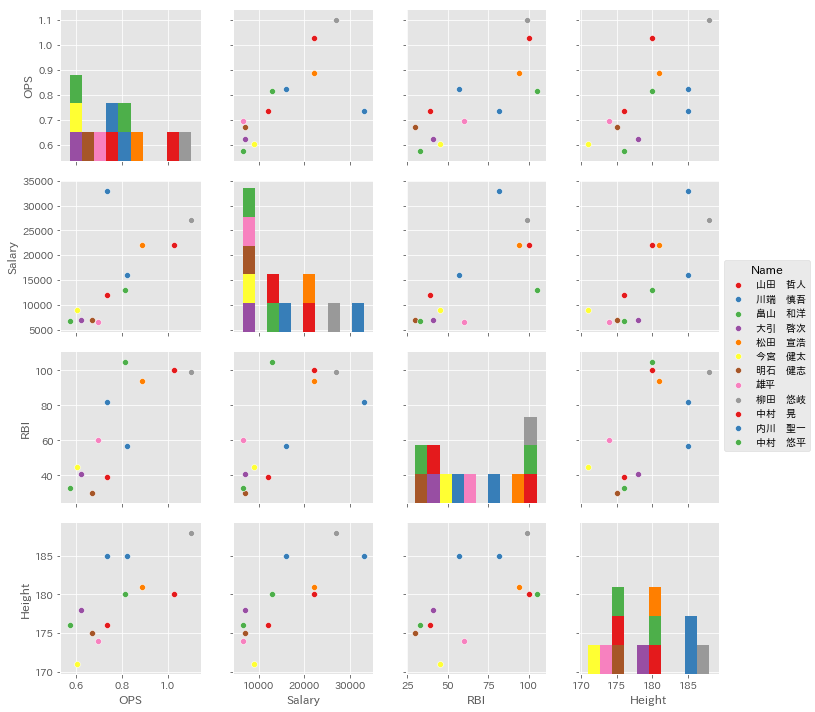

In [60]:
#sns.pairplot(YS.iloc[:,[0,1,2,3,4,5]], hue="Name", palette='Set1')
sns.pairplot(YS.loc[:,['Name','OPS','Salary','RBI','Height']], hue="Name", palette='Set1')
plt.show()

- このプロットより、OPSとSalary、およびOPSとRBIの間に正の相関関係がありそうである。

### 3.3. バープロット
- 年俸の分布を、選手名やチームについて調べる。

<BarContainer object of 12 artists>

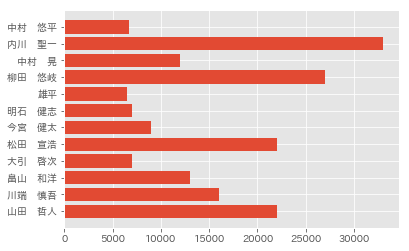

In [17]:
plt.barh(YS['Name'], YS['Salary'])

In [18]:
plt.bar(YS['Team_16'], YS['Salary'][YS['Position']='野手'])

SyntaxError: invalid syntax (<ipython-input-18-05c1d69a499d>, line 1)

### 3.4. 散布図

/usr/local/python/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


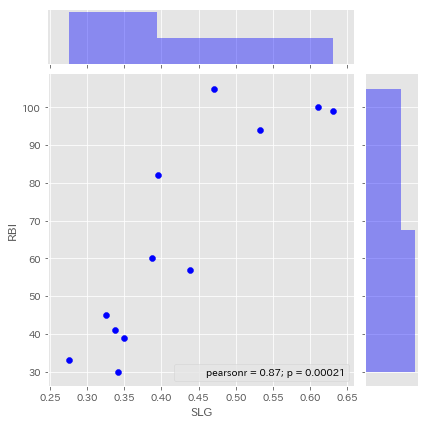

In [25]:
sns.jointplot(x='SLG', y='RBI', data=YS, color='b')

## 4. 回帰分析で比較

- OPSとRBIの相関関係を、回帰分析を行い調査する。
$$
OPS = 長打率 + 出塁率 \\
長打率 = \frac{単打 + 二塁打 \times 2 + 三塁打 \times 3 + 本塁打 \times 4}{打数} \\
出塁率 = \frac{安打 + 四球 + 死球}{打数 + 四球 + 死球 + 犠飛}
$$
OPSは打者の評価指標として用いられ、単にヒットを打ったかどうかの打率ではなく、いかにアウトにならないか(出塁率)、いかに得点に近づけるか(長打率)に主眼を置いている。

### 4.1. 散布図と相関係数
- 散布図と相関係数からOPSとRBI(打点)の関係を見てみる。

/usr/local/python/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


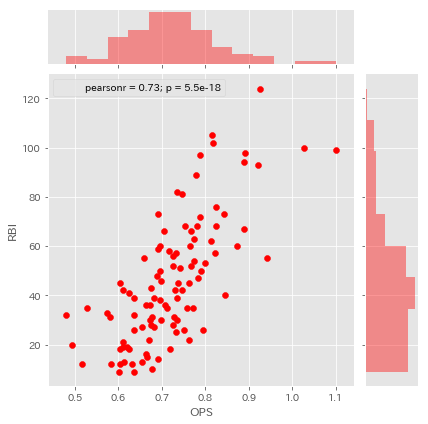

In [28]:
sns.jointplot(x='OPS', y='RBI', data=batter, label='Name', color='r')

- 散布図よりOPSが増加するにつ入れてRBIも増加しているため、制の相関があることがわかる。
- 次に、その関係の強さを数値的に把握するために相関係数(および共分散)を求める。
$$
\verb|OPSと打点の共分散:|Cov(OPS,RBI) = \frac{1}{N-1} \sum_{i=1}^N (OPS_i - \mu_{OPS})(RBI_i - \mu_{RBI}) \\
\verb|OPSと打点の相関係数:|\rho_{OPS,RBI} = \frac{Cov(OPS,RBI)}{\sqrt{\sigma_{OPS}^2 \sigma_{RBI}^2}}
$$

In [66]:
# Calculate Covariance.
cov = sp.cov(batter['OPS'], batter['RBI'], ddof=1)[0][1]
print("共分散 : {0:.3f}".format(cov))

# Calculate Correlation Coefficient.
rho = sp.corrcoef(batter['OPS'], batter['RBI'])#[0][1]
#print("相関係数 : {0:.3f}".format(rho))
rho

共分散 : 1.942


array([[1.        , 0.72654537],
       [0.72654537, 1.        ]])

- 相関係数が0.73になっており、2変数にやや強い正の相関があることがわかる。

### 4.2. 分割表とカイ二乗検定
- データ間に統計的相関が見られるか確認してみる。分割表の変数が独立であるかカイ二乗検定を適用する。
- まず変数を2値化して、分割表を作成する。ここでは、より多くのOPSおよびRBI(打点)をとっている場合にはTrue、そうでなければFalseとする。

In [72]:
batter['OPS_bi'] = batter['OPS'] > batter['OPS'].median()
batter['RBI_bi'] = batter['RBI'] > batter['RBI'].median()
cross = pd.crosstab(batter['OPS_bi'], batter['RBI_bi']).dropna()
cross.head()

RBI_bi,False,True
OPS_bi,,
False,39,12
True,12,39


- 帰無仮説は「2つの変数はそれぞれ独立である」としてカイ二乗検定を適用する。

In [73]:
st.chi2_contingency(cross)

(26.50980392156863, 2.622040350594582e-07, 1, array([[25.5, 25.5],
        [25.5, 25.5]]))

- これより、p値=$2.6\times 10^{-7}$となり、0.05(=累積確率5%)と比較して非常に小さいため、帰無仮説が棄却され、OPSとRBI(打点)との間には、統計的に明確な相関があることが示された。

### 4.2. 散布図と回帰直線
- OPSとRBIの散布図に対して、回帰直線を適用する。
- 回帰直線自体はseabornのlmplot関数を用いて簡単に図示することができる。網掛け部分は回帰直線の95%信頼区間を表している。

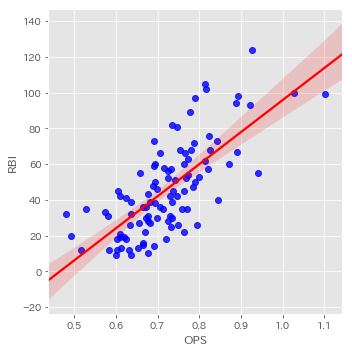

In [51]:
sns.lmplot(x='OPS', y='RBI', data=batter, scatter_kws={'color':'b'}, line_kws={'color':'r'})

- 正規線形モデル推定"statsmodels.formula.api"において"ols(最小二乗法)"を用いる。
- ここでは"formula"において、応答変数をRBI、説明変数をOPSとする推定を行う。
- 最後に".fit()"をつけてフィッテイングを行う。これでパラメタ推定までが自動的に終わる。

In [76]:
lm_model = smf.ols(formula="RBI ~ OPS", data=batter).fit()

In [77]:
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RBI   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     111.8
Date:                Mon, 18 Jun 2018   Prob (F-statistic):           5.48e-18
Time:                        12:54:53   Log-Likelihood:                -437.05
No. Observations:                 102   AIC:                             878.1
Df Residuals:                     100   BIC:                             883.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -83.5958     12.362     -6.762      0.000    -108.122     -59.069
OPS          179.4126     16.968     10.574      0.000     145.749     213.076
==============================================================================
Omnibus:                        3.430   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.180   Jarque-Bera (JB):                3.420
Skew:                           0.413   Prob(JB):                        0.181
Kurtosis:                       2.648   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- この二つ目の分割表より、回帰式は
$$ y(RBI) = 179.41 \times (OPS) - 83.60 $$
となる。
- また帰無仮説を「RBIに対するOPSの係数の値が0である」としたときのp値があまりに小さすぎて、桁落ちで0となっている。RBIに対してOPSにかかる係数は有意に0とは異なると判断できる。